In [ ]:
import sys
sys.version_info

In [1]:
import os.path as op

import mne
import pyxdf
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
from utils import Preprocessing

In [ ]:
#import importlib
#importlib.reload(Preprocessing)

In [ ]:
subjs = ["%03d" % x for x in range(0,3)]
#subjs = ["%03d" % x for x in range(0,182)]
#subjs = '001'

In [ ]:
print(subjs)

In [ ]:
sessions = ["%03d" % x for x in range(1,4)]
#sessions = '001'

In [ ]:
print(sessions)

In [ ]:
def make_file_path(prefix, subj, session):
    return prefix + "sub-P"+subj+"/ses-S"+session+"/eeg/sub-P"+subj+"_ses-S"+session+"_task-Default_run-001_eeg.xdf"

In [ ]:
prefix = "/mnt/ccsl_nas/box_sync/tangram_eeg/study1/raw_data/"
#prefix = "/home/rwhuskey/Downloads/"

In [ ]:
print(prefix)

In [ ]:
#file = make_file_path(prefix, subjs, sessions)

In [ ]:
#print(file)

In [ ]:
from IPython.display import clear_output

In [ ]:
import os

In [ ]:
## Import participant data and run autoreject

# Define preprocess_dict, which is where synchronized streams + autoreject for
# each participant pair for each session are stored
preprocess_dict = {}

for subj in subjs:
    subj_df_dict = {}
    for session in sessions:
        
        # reference each xdf file for each pair of participants for each session
        file = make_file_path(prefix, subj, session)
        
        # Read in xdf file, synchronize streams, and structure for each 
        # participant for each electrode
        if os.path.isfile(file):
            try:
                print("processing subj: {} session: {}".format(subj, session))
                streams, header  = pyxdf.load_xdf(file, select_streams=[{'type': 'EEG'}])
                streams = streams[:2]
                streams = Preprocessing._sync_timestamps(streams, kind='linear')
                streams = Preprocessing._limit_streams_to_overlap(streams)
                
                if streams[0]['info']['name'][0][5:9] == 'AC76':
                    director = streams[0]
                    matcher = streams[1]
                elif streams[0]['info']['name'][0][5:9] == 'AC7D':
                    director = streams[1]
                    matcher = streams[0]
                else:
                    raise Exception("stream naming incorrect")
                
                # timeseries for first participant in the xdf
                # runs autoreject (from preprocessing.py)
                # autoreject parameters are specified in preprocssing.py
                timeseries_p1 = Preprocessing.preprocessing_autoreject(director)
                # timeseries for second participant in the xdf
                # runs autoreject (from preprocessing.py)
                # autoreject parameters are specified in preprocssing.py
                timeseries_p2 = Preprocessing.preprocessing_autoreject(matcher)
                
                # structure autorejected timeseries for both participants
                pair_df = pd.concat([timeseries_p1, timeseries_p2.iloc[:,3:]], axis=1)
                
                # name column headers
                pair_df.columns = ["index", "epoch", "time", "TP9-1", "AF7-1", "AF8-1", "TP10-1", "TP9-2", "AF7-2", "AF8-2", "TP10-2"]
                clear_output()

                subj_df_dict[session] = pair_df
            except:
                print("Failed subj: {} session: {}".format(subj, session))
            
    if os.path.exists(prefix+"sub-P"+subj):
        preprocess_dict[subj] = subj_df_dict



# dump data as pickle files

In [ ]:
import pickle

In [ ]:
# Un-comment this code if you want to save a new pickle file
# The code is currently commented out to prevent
# accidental file overwrite

# Filehandler is for writing a pickle file
#filehandler = open("preprocessed_data.obj","wb")

# Pickle preprocess_dict
#pickle.dump(preprocess_dict,filehandler)
#filehandler.close()

In [ ]:
# after pre-processing is complete (i.e., load in data + autoreject)
# start here by loading in the preprocessed and structured data

# This code defines file for opening a pickeled object
file = open("preprocessed_data.obj",'rb')

# This code reads in the pickle file
preprocess_dict = pickle.load(file)
file.close()

# Save data as a long dataframe

In [ ]:
# define empty variables for structuring data
eeg_long_df_list = []
subj_list = []
ses_list = []

# For loop that reads in data from preprocess_dict and stores it with the new variables
for subj in list(preprocess_dict.keys()):
    for ses in list(preprocess_dict[subj].keys()):
        temp_df = preprocess_dict[subj][ses]
        eeg_long_df_list.append(temp_df)
        subj_list.append([subj] * temp_df.shape[0])
        ses_list.append([ses] * temp_df.shape[0])
        
subj_list = [item for sublist in subj_list for item in sublist]
ses_list = [item for sublist in ses_list for item in sublist]

In [ ]:
len(subj_list)

In [ ]:
len(ses_list)

In [ ]:
# convert the list to a dataframe
eeg_long_df = pd.concat(eeg_long_df_list).reset_index()

In [ ]:
eeg_long_df.shape

In [ ]:
len(eeg_long_df)

In [ ]:
# add subj_list and ses_list to eeg_long_df
eeg_long_df["subj"] = subj_list
eeg_long_df["ses"] = ses_list

In [ ]:
eeg_long_df

In [ ]:
# export the dataframe to a csv file for later processing
eeg_long_df.to_csv("big_preprocessed_eeg_df.csv")

In [ ]:
# This code reads the structured csv file in
# Uncomment this code if you want to start back here

eeg_long_df = pd.read_csv("big_preprocessed_eeg_df.csv")

In [ ]:
import numpy as np

In [ ]:
# this code replaces zero wit nan
eeg_long_df[["TP9-1", "AF7-1", "AF8-1", "TP10-1", "TP9-2", "AF7-2", "AF8-2", "TP10-2"]] = \
eeg_long_df.loc[:, ["TP9-1", "AF7-1", "AF8-1", "TP10-1", "TP9-2", "AF7-2", "AF8-2", "TP10-2"]].replace(0, np.nan)

In [ ]:
eeg_long_df

In [ ]:
# Measure EEG inter-subject correlation
# Make a big correlation matrix for:
    # each electrode for each pair of participants
# Then index that correlation matrix, selecting the correct cell
# and restructuring as a dataframe

corr_df_TP9 = eeg_long_df.groupby(["subj", "ses"])[["TP9-1", "TP9-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]
corr_df_AF7 = eeg_long_df.groupby(["subj", "ses"])[["AF7-1", "AF7-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]
corr_df_AF8 = eeg_long_df.groupby(["subj", "ses"])[["AF8-1", "AF8-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]
corr_df_TP10 = eeg_long_df.groupby(["subj", "ses"])[["TP10-1", "TP10-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]

# combine individual electrode correlation dataframes into one big dataframe 
corr_df = pd.concat([corr_df_TP9, corr_df_AF7, corr_df_AF8, corr_df_TP10], axis=1)
corr_df.columns = ["TP9", "AF7", "AF8", "TP10"]
corr_df["subj"] = eeg_long_df.groupby(["subj", "ses"])[["TP9-1", "TP9-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,0]
corr_df["ses"] = eeg_long_df.groupby(["subj", "ses"])[["TP9-1", "TP9-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,1]

In [ ]:
# export the correlation dataframe to a csv file for later analysis
corr_df.to_csv("big_preprocessed_eeg_corr_df.csv")

In [ ]:
corr_df = pd.read_csv("big_preprocessed_eeg_corr_df.csv")

In [ ]:
corr_df_TP9

In [ ]:
corr_df

# Load task performance

In [ ]:
# read in the behavioral data
# This is old code to be deleted
# it originally read in an csv file that needed structuring, the subsequent code did the structuring

#task_performance_df = pd.read_csv("task_performance.csv")

#task_performance_df

In [ ]:
# this is old code that structured a file

#task_performance_df["subj"] = np.repeat(task_performance_df.subj.dropna().astype(int).tolist(), 3)
#task_performance_df["ses"] = np.tile(np.arange(1,4), task_performance_df.subj.unique().shape[0])

In [ ]:
# this is old code that structured a file

#task_performance_df = task_performance_df[["Performance", "Time (sec)", "Signal Drop", "subj", "ses"]]
#task_performance_df = task_performance_df.dropna()

In [ ]:
# this is old code that structured a file and saved it

#task_performance_df
#task_performance_df.to_csv("task_performance_new.csv")

In [ ]:
#read in the structured task performance data

task_performance_df = pd.read_csv("task_performance.csv")

In [ ]:
from scipy.stats import pearsonr

In [ ]:
corr_df["subj"] = corr_df["subj"].astype(int)
corr_df["ses"] = corr_df["ses"].astype(int)

In [ ]:
corr_df

In [ ]:
corr_df = corr_df.merge(task_performance_df, on=["subj", "ses"], how="left")

In [ ]:
corr_df = corr_df.dropna()

In [ ]:
corr_df

In [ ]:
corr_df.subj.unique().shape[0]

In [ ]:
corr_df.to_csv("merged_corr_df.csv")

# Statistical testing

In [2]:
# Read in the structured correlation data

corr_df = pd.read_csv("merged_corr_df.csv")

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

In [6]:
# Make "subj" and "ses" strings

corr_df['subj'] = corr_df['subj'].astype(str)
corr_df['ses'] = corr_df['ses'].astype(str)

In [11]:
# Repeated measures ANOVA with TP9 as DV
# and subject as IV and session as repeated measure
# this code currently breaks because we have unbalanced repeated observations
# so lets try a mixed model

print(AnovaRM(data=corr_df, depvar='TP9',
              subject='subj', within=['ses'], aggregate_func='mean').fit())

ValueError: Data is unbalanced.

In [21]:
# This formula specifies a model with 'TP9' as the response, 'ses' as a fixed effect,
# and random intercepts for each subject.
# just replace the dv for each electrode to check if ISC changes over time as a function of session
# spoiler alert, it does not

model = smf.mixedlm("AF7 ~ ses", corr_df, groups=corr_df["subj"])
result = model.fit()

print(result.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: AF7     
No. Observations: 233     Method:             REML    
No. Groups:       119     Scale:              0.0127  
Min. group size:  1       Log-Likelihood:     162.4067
Max. group size:  3       Converged:          Yes     
Mean group size:  2.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.009    0.013  0.681 0.496 -0.016  0.034
ses[T.2]    -0.016    0.018 -0.877 0.380 -0.052  0.020
ses[T.3]    -0.018    0.018 -1.010 0.312 -0.054  0.017
Group Var    0.001    0.009                           



/home/rwhuskey/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [22]:
# fit an ols with TP10 as outcome variable
# and session as the IV
moore_lm = ols('TP10 ~ C(ses)',
             data=corr_df).fit()
# print results 
table = sm.stats.anova_lm(moore_lm) # Type 2 ANOVA DataFrame
print(table)

# fit an ols with TP9 as outcome variable
# and session as the IV
moore_lm = ols('TP9 ~ C(ses)',
             data=corr_df).fit()

# print results 
table = sm.stats.anova_lm(moore_lm) # Type 2 ANOVA DataFrame
print(table)

# fit an ols with AF7 as outcome variable
# and session as the IV
moore_lm = ols('AF7 ~ C(ses)',
             data=corr_df).fit()

# print results 
table = sm.stats.anova_lm(moore_lm) # Type 2 ANOVA DataFrame
print(table)

# fit an ols with AF8 as outcome variable
# and session as the IV
moore_lm = ols('AF8 ~ C(ses)',
             data=corr_df).fit()

# print results 
table = sm.stats.anova_lm(moore_lm) # Type 2 ANOVA DataFrame
print(table)

             df    sum_sq   mean_sq         F    PR(>F)
C(ses)      2.0  0.024709  0.012355  1.679304  0.188782
Residual  230.0  1.692118  0.007357       NaN       NaN
             df    sum_sq   mean_sq         F    PR(>F)
C(ses)      2.0  0.032672  0.016336  2.882569  0.058016
Residual  230.0  1.303460  0.005667       NaN       NaN
             df    sum_sq   mean_sq         F    PR(>F)
C(ses)      2.0  0.014713  0.007357  0.544231  0.581033
Residual  230.0  3.109061  0.013518       NaN       NaN
             df    sum_sq   mean_sq         F    PR(>F)
C(ses)      2.0  0.017278  0.008639  0.840718  0.432722
Residual  230.0  2.363432  0.010276       NaN       NaN


In [23]:
# set as integer session

corr_df["ses"] = corr_df["ses"].astype(int)

In [25]:
# This filters out extreme values that are > +/-.2
# mostly useful for plotting

filter_index = (corr_df[["TP10", "AF7", "AF8", "TP9"]] > 0.2).any(1)  | (corr_df[["TP10", "AF7", "AF8", "TP9"]] < -0.2).any(1)

In [27]:
filter_index

0      False
1       True
2      False
3      False
4      False
       ...  
228    False
229    False
230    False
231     True
232    False
Length: 233, dtype: bool

In [31]:
filter_index.sum()

30

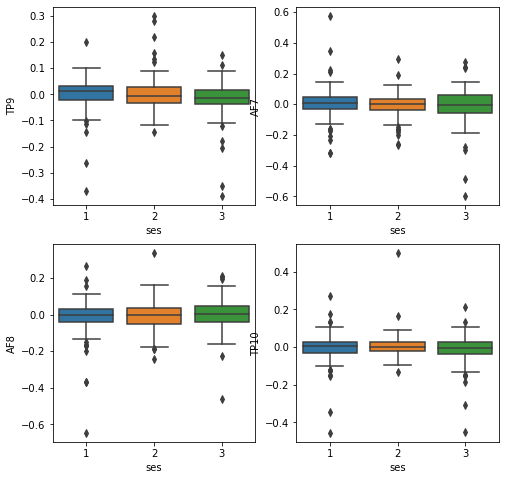

In [29]:
# plot correlation by electrode by sessions

fig, axs = plt.subplots(2,2,figsize=(8,8))

channels = ["TP9", "AF7", "AF8", "TP10"]
for i in range(4):
    sns.boxplot(x = corr_df.ses, y = corr_df[channels[i]], ax=axs[i//2, i%2])

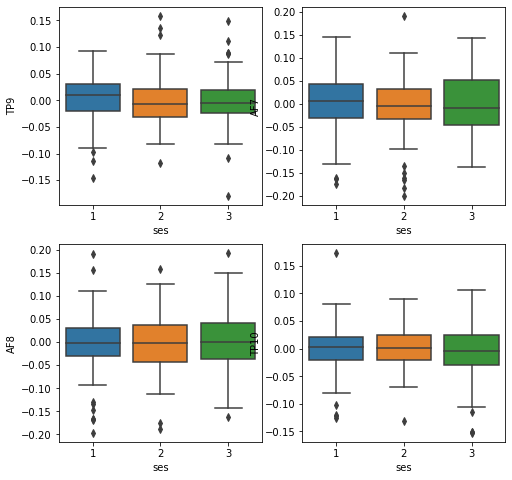

In [26]:
# plot correlation by electrode by sessions
# but filter out extreme values to make it easier to examine

fig, axs = plt.subplots(2,2,figsize=(8,8))

channels = ["TP9", "AF7", "AF8", "TP10"]
for i in range(4):
    sns.boxplot(x = corr_df[~filter_index].ses, y = corr_df[~filter_index][channels[i]], ax=axs[i//2, i%2])

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, tol=1, random_state=0).fit(corr_df[["TP10", "AF7", "AF8", "TP9"]])

labels = gmm.predict(corr_df[["TP10", "AF7", "AF8", "TP9"]])
labels.sum()

In [33]:
from scipy.stats.stats import pearsonr

/tmp/ipykernel_257799/4005289447.py:1: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [35]:
# make a bunch of correlation matrix for each electrode
# with isc and performance
# on whole dataset

print(pearsonr(corr_df.TP9, corr_df.Performance))
print(pearsonr(corr_df.AF7, corr_df.Performance))
print(pearsonr(corr_df.AF8, corr_df.Performance))
print(pearsonr(corr_df.TP10, corr_df.Performance))

PearsonRResult(statistic=0.023096994554691982, pvalue=0.7258051633752469)
PearsonRResult(statistic=0.1523305585977157, pvalue=0.02000188885660745)
PearsonRResult(statistic=-0.07267683563867067, pvalue=0.2692206030947382)
PearsonRResult(statistic=0.004837747328917157, pvalue=0.9414493900711886)


In [34]:
# make a bunch of correlation matrix for each electrode
# with isc and performance
# on arbitrarially filtered data

print(pearsonr(corr_df[~filter_index].TP9, corr_df[~filter_index].Performance))
print(pearsonr(corr_df[~filter_index].AF7, corr_df[~filter_index].Performance))
print(pearsonr(corr_df[~filter_index].AF8, corr_df[~filter_index].Performance))
print(pearsonr(corr_df[~filter_index].TP10, corr_df[~filter_index].Performance))

PearsonRResult(statistic=-0.006121855845238784, pvalue=0.9309217284857104)
PearsonRResult(statistic=0.17650592127027862, pvalue=0.011765436347785185)
PearsonRResult(statistic=-0.06093300689331127, pvalue=0.3878057535679795)
PearsonRResult(statistic=-0.12442991347104858, pvalue=0.07692956322418404)


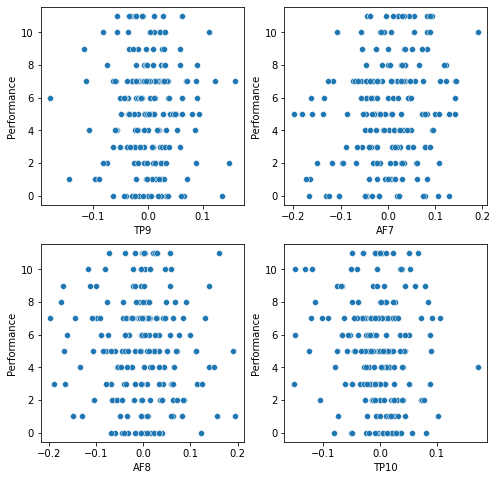

In [36]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

channels = ["TP9", "AF7", "AF8", "TP10"]
for i in range(4):
    sns.scatterplot(x = corr_df[~filter_index][channels[i]], y = corr_df[~filter_index].Performance, ax=axs[i//2, i%2])

In [ ]:
fig, axs = plt.subplots(2,figsize=(8,8))

fig.suptitle('Time series data for two participates')

for i in range(2):
    y = streams[i]['time_series'][10:-10,:]
    x = streams[i]['time_stamps'][10:-10]
    axs[i].plot(x, y)

plt.show()

In [ ]:
fig, axs = plt.subplots(2,figsize=(8,8))

fig.suptitle('Time series data for two participates')
axs[0].plot(pair_df.iloc[:,3:7])
axs[1].plot(pair_df.iloc[:,7:])

plt.show()

In [ ]:
import numpy as np

In [ ]:
TP9_corr = pair_df[["TP9-1", "TP9-2"]].corr().iloc[0,1]
TP10_corr = pair_df[["TP10-1", "TP10-2"]].corr().iloc[0,1]
AF7_corr = pair_df[["AF7-1", "AF7-2"]].corr().iloc[0,1]
AF8_corr = pair_df[["AF8-1", "AF8-2"]].corr().iloc[0,1]

print("the TP9 correlation is ", TP9_corr)
print("the TP10 correlation is ", TP10_corr)
print("the AF7 correlation is ", AF7_corr)
print("the AF8 correlation is ", AF8_corr)

print("the average correlation is ", 
      np.mean([TP9_corr,TP10_corr,AF7_corr,AF8_corr]))

In [ ]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
U_c, V_c = cca.fit_transform(pair_df.iloc[:,3:7], pair_df.iloc[:,7:])
result = np.corrcoef(U_c.T, V_c.T)[0,1]
result

1. got all of the data and task performance
2. 

## testing
# dont run
subj = "003"
session = "002"
file = make_file_path(prefix, subj, session)
streams, header  = pyxdf.load_xdf(file, select_streams=[{'type': 'EEG'}])
streams = streams[:2]
streams = Preprocessing._sync_timestamps(streams, kind='linear')
streams = Preprocessing._limit_streams_to_overlap(streams)